In [1]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql.functions import *
from pyspark.sql.types import BooleanType
colors = {
    "Blue": "#1f77b4",
    "Green": "#2ca02c",
    "Red": "#d62728",
    "Grey": "#7f7f7f",
}

from datetime import datetime
import holidays

from pyspark.sql import SparkSession
import os

event_log_dir = "/tmp/spark-events"
os.makedirs(event_log_dir, exist_ok=True)

total_memory_gb = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024. ** 3)

spark = SparkSession.builder \
    .appName("GeoAnalysisDDAM") \
    .config("spark.executor.memory", f"{int(total_memory_gb * 0.8)}g") \
    .config("spark.driver.memory", f"{int(total_memory_gb * 0.8)}g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", "/tmp/spark-events") \
    .getOrCreate()

sc = spark.sparkContext

file_path = '/content/drive/MyDrive/DDAM Group 2/geo_offline_pre_combined.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)

Mounted at /content/drive
root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- prev_lat: double (nullable = true)
 |-- prev_long: double (nullable = true)
 |-- distance_from_home: double (nullable = true)

+---------------------+-----------+------------+-------------+-----+-------+--------+--------------------+------------------+------------------+--------+----+---+-----+---+------------------+------------------+------------------+
|trans_date_trans

# Spatial Clustering

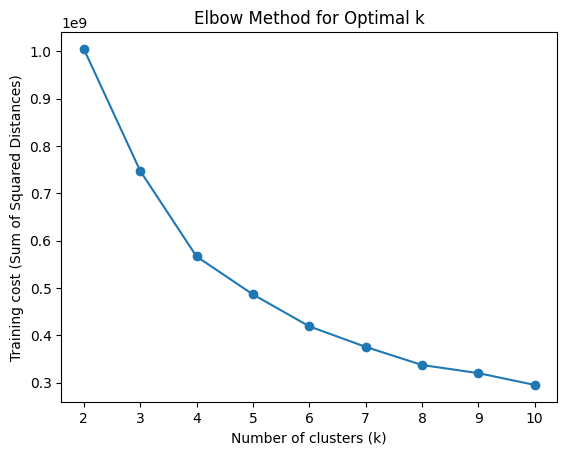

CPU times: user 4.99 s, sys: 569 ms, total: 5.56 s
Wall time: 6min 43s


In [2]:
%%time
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Step 1: Prepare data for clustering by combining geospatial features into a single vector
assembler = VectorAssembler(inputCols=['lat', 'long', 'merch_lat', 'merch_long', 'prev_lat', 'prev_long', 'distance_from_home'], outputCol='features')
clustered_data = assembler.transform(df)

# Step 2: Keep `is_fraud` column in the DataFrame
# This will ensure we can filter out fraud transactions later
clustered_data = clustered_data.select('trans_num', 'is_fraud', 'lat', 'long', 'merch_lat', 'merch_long', 'prev_lat', 'prev_long', 'distance_from_home', 'features')

# Elbow method to find optimal number of clusters
costs = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(k=k, seed=1, featuresCol='features', predictionCol='cluster')
    model = kmeans.fit(clustered_data)
    costs.append(model.summary.trainingCost)

plt.plot(k_range, costs, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Training cost (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [3]:
kmeans = KMeans(k=4, seed=1, featuresCol='features', predictionCol='cluster')
model = kmeans.fit(clustered_data)
predictions = model.transform(clustered_data)

# Silhouette Score
evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='features')
sil_score = evaluator.evaluate(predictions)
print(f"Silhouette Score: {sil_score}")

# Filter out fraudulent transactions
fraudulent_transactions = predictions.filter(predictions.is_fraud == 1)

Silhouette Score: 0.4664689727998082


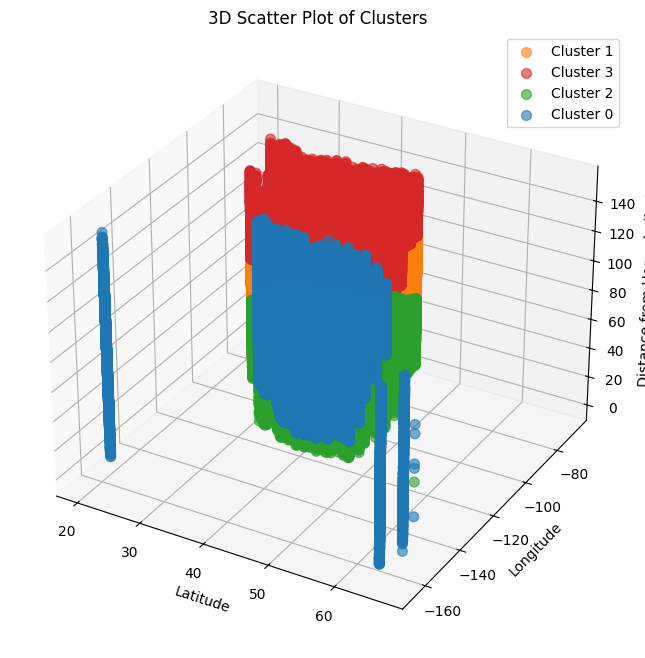

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import col

# Define fixed colors for the clusters
cluster_colors = {
    0: '#1f77b4',  # Blue
    1: '#ff7f0e',  # Orange
    2: '#2ca02c',  # Green
    3: '#d62728'   # Red
}

# Load predictions into pandas DataFrame
df_pandas = predictions.select('lat', 'long', 'distance_from_home', 'cluster').toPandas()

# 3D Scatter Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster with fixed colors
for cluster_id in df_pandas['cluster'].unique():
    cluster_data = df_pandas[df_pandas['cluster'] == cluster_id]
    ax.scatter(
        cluster_data['lat'],
        cluster_data['long'],
        cluster_data['distance_from_home'],
        label=f'Cluster {cluster_id}',
        s=50,  # Marker size
        alpha=0.6,
        color=cluster_colors[cluster_id]  # Use the defined color
    )

# Set plot labels and title
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Distance from Home (miles)')
ax.set_title('3D Scatter Plot of Clusters')
ax.legend()

plt.show()

In [5]:
# Geospatial Analysis with Folium
states_gdf = gpd.read_file("/content/us-state-boundaries.shp")
states_gdf.crs = "EPSG:4326"

# Convert Spark predictions to GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    df_pandas,
    geometry=gpd.points_from_xy(df_pandas['long'], df_pandas['lat']),
    crs="EPSG:4326"
)

gdf_points['state'] = gpd.sjoin(gdf_points, states_gdf, how="left", predicate='within')['name']
state_cluster_counts = gdf_points.groupby(['state', 'cluster']).size().reset_index(name='count')
majority_clusters = state_cluster_counts.groupby('state').apply(
    lambda x: x.loc[x['count'].idxmax()]
).reset_index(drop=True)

# Map states to the majority cluster's color
state_colors = {row['state']: cluster_colors[row['cluster']] for _, row in majority_clusters.iterrows()}

# Create Folium map
center_lat = df_pandas['lat'].mean()
center_long = df_pandas['long'].mean()
m = folium.Map(location=[center_lat, center_long], zoom_start=4, tiles='CartoDB positron')

for _, state in states_gdf.iterrows():
    state_name = state['name']
    state_geometry = state['geometry']

    if state_name in state_colors:
        color = state_colors[state_name]
        folium.GeoJson(
            state_geometry,
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': color,
                'weight': 1,
                'fillOpacity': 0.7
            },
        ).add_to(m)

m.save("us_states_majority_cluster_map.html")

<ipython-input-5-e74a87b4ee5b>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  majority_clusters = state_cluster_counts.groupby('state').apply(


Boundaries data: https://public.opendatasoft.com/explore/dataset/us-state-boundaries/export/